# T00 - Toy Demonstration

Application of the PAWS method on analytic distributions and pseudo datasets

## I - Formulation

The output the supervised classifier is the posterior probability of signal ($y = 1$):

$$f_{\text{FS}}(x, \theta) = \frac{P_S(x|\theta)P_S(\theta)}{P_S(x|\theta)P_S(\theta) + P_B(x|\theta)P_B(\theta)}$$

which relates to the likelihood by

$$\Lambda_{\text{FS}} = \frac{P_B(\theta)}{P_S(\theta)} \frac{f_{\text{FS}}}{1 - f_{\text{FS}}} = \kappa(\theta) \frac{f_{\text{FS}}}{1 - f_{\text{FS}}},\quad \text{ where } \kappa(\theta) \text{ is the prior ratio between bkg and sig}$$

Similarly for the semi-weakly model:

$$f_{\text{WS}} = \frac{P_D(x)P_D}{P_D(x)P_D + P_R(x)P_R}$$

Observe that the data densities can be expressed in terms of the signal and background densities:

$$P_D(x) = \mu P_S(x) + (1 - \mu) P_B(x)$$

The prior probabilities of data $P_D$ and reference $P_R$ can be related by:

$$P_D = P_R + \frac{\mu}{1 - \mu} P_R = \frac{1}{1 - \mu} P_R$$

Expanding terms gives:

$$f_{\text{WS}}(\theta) = \dfrac{\mu\kappa(\theta)\dfrac{f_{\text{FS}}}{1 - f_{\text{FS}}} + 1 - \mu}{\mu\kappa(\theta)\dfrac{f_{\text{FS}}}{1 - f_{\text{FS}}} + 2(1-\mu)}$$

## II - Demonstration

In [1]:
import sys
from collections import defaultdict
from itertools import repeat
from concurrent.futures import ProcessPoolExecutor

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal, expon
from scipy.optimize import minimize, minimize_scalar

In [2]:
def get_R(model_B, N_B, seed=None):
    random_state = np.random.RandomState(seed) if seed is not None else None
    return model_B.rvs(size=N_B, random_state=random_state)

def get_D(model_S, model_B, N_B, mu_inj, seed=None):
    N_S = int(mu_inj / (1 - mu_inj) * N_B)
    random_state = np.random.RandomState(seed + 1) if seed is not None else None
    return np.concatenate([model_S.rvs(size=N_S, random_state=random_state),
                           model_B.rvs(size=N_B, random_state=random_state)])

def get_pS_over_pB(x, model_S, model_B):
    return model_S.pdf(x) / model_B.pdf(x)

def get_FS(x, model_S, model_B):
    pS_over_pB = get_pS_over_pB(x, model_S, model_B)
    return pS_over_pB / (1 - pS_over_pB)

def get_WS(x, mu, model_S, model_B):
    pS_over_pB = get_pS_over_pB(x, model_S, model_B)
    return (mu * pS_over_pB + 1 - mu) / (mu * pS_over_pB + 2 - 2 * mu)

def get_BCE(x, y, mu, model_S, model_B):
    WS = get_WS(x, mu, model_S, model_B)
    overflow = (1 - WS) <= 0.
    underflow = WS <= 0.
    WS[overflow] = 1 - 1e-6
    WS[underflow] = 1e-6
    return - y * np.log(WS) - (1. - y) * np.log(1. - WS )

def get_total_loss(D, R, mu, model_S, model_B):
    y = np.concatenate([np.ones(D.shape[0]), np.zeros(R.shape[0])])
    x = np.concatenate([D, R])
    return np.mean(get_BCE(x, y, mu, model_S, model_B))

def get_loss_over_mu(D, R, mu_list, model_S, model_B):
    data = []
    for mu in mu_list:
        data.append({
            'mu': mu,
            'loss': get_total_loss(D, R, mu, model_S, model_B)
        })
    return data

def run_trial(mu, trial, N_B, model_S, model_B):
    sys.stdout.write(f'Running trial {trial + 1} with mu = {mu}\n')
    R = get_R(model_B, N_B, seed=trial)
    D = get_D(model_S, model_B, N_B, mu, seed=trial)
    func = lambda x : get_total_loss(D, R, x, model_S, model_B)
    #func = lambda x : np.mean(get_BCE(D, 1 , x, model_S, model_B)) + np.mean(get_BCE(R, 0 , x, model_S, model_B))
    res = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
    mu_hat = res.x
    return [mu, mu_hat]

def scan_mu_hat(mu_list, N_B, N_trial, model_S, model_B, max_workers=None):
    mu_args = np.repeat(mu_list, N_trial)
    trial_args = np.tile(np.arange(N_trial), len(mu_args))
    outputs = []
    if max_workers == 0:
        for mu, trial in zip(mu_args, trial_args):
            outputs.append(run_trial(mu, trial, N_B, model_S, model_B))
    else:
        with ProcessPoolExecutor(max_workers=max_workers) as executor:
            outputs = list(executor.map(run_trial, mu_args, trial_args, repeat(N_B), repeat(model_S), repeat(model_B)))
    outputs = np.array(outputs)
    result = defaultdict(list)
    for output in outputs:
        result[output[0]].append(output[1])
    return result

def create_mu_plot(mu_hats, title: str = ''):
    mu_trues = np.array(list(mu_hats))
    mu_hats = np.array([values for values in mu_hats.values()])
    mu_mean = np.mean(mu_hats, axis=1)
    mu_std = np.std(mu_hats, axis=1)
    plt.fill_between(mu_trues, mu_mean - mu_std, mu_mean + mu_std, alpha=0.2)
    plt.plot(mu_trues, mu_mean)
    plt.plot(mu_trues, mu_trues, linestyle=":", color="gray")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("True $\mu$")
    plt.ylabel("Fitted $\mu$")
    plt.title(title)
    plt.show()

### Analytic Distributions - 1D Gaussian

In [3]:
mu_inj_list = np.logspace(-2, -0.3, 10)
N_trial = 10
N_B = 100000
seed = 2024

mu_S = 3
mu_B = 6
sigma = 1

model_S = multivariate_normal(mean=mu_S, cov=sigma, seed=seed)
model_B = multivariate_normal(mean=mu_B, cov=sigma, seed=seed)

mu_hats = scan_mu_hat(mu_inj_list, N_B, N_trial, model_S, model_B, max_workers=25)

Running trial 1 with mu = 0.01
Running trial 3 with mu = 0.01
Running trial 2 with mu = 0.01
Running trial 4 with mu = 0.01
Running trial 5 with mu = 0.01
Running trial 6 with mu = 0.01
Running trial 7 with mu = 0.01
Running trial 8 with mu = 0.01
Running trial 9 with mu = 0.01
Running trial 10 with mu = 0.01
Running trial 1 with mu = 0.015448591479026755
Running trial 2 with mu = 0.015448591479026755
Running trial 3 with mu = 0.015448591479026755
Running trial 4 with mu = 0.015448591479026755
Running trial 5 with mu = 0.015448591479026755
Running trial 10 with mu = 0.015448591479026755
Running trial 9 with mu = 0.015448591479026755
Running trial 2 with mu = 0.023865897868585808
Running trial 7 with mu = 0.015448591479026755
Running trial 4 with mu = 0.023865897868585808
Running trial 1 with mu = 0.023865897868585808
Running trial 3 with mu = 0.023865897868585808
Running trial 8 with mu = 0.015448591479026755
Running trial 5 with mu = 0.023865897868585808
Running trial 6 with mu = 0.01

/tmp/ipykernel_174446/909118199.py:50: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_174446/909118199.py:50: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_174446/909118199.py:50: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_174446/909118199.py:50: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_174446/909118199.py:50: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.


Running trial 6 with mu = 0.023865897868585808
Running trial 7 with mu = 0.023865897868585808
Running trial 8 with mu = 0.023865897868585808
Running trial 9 with mu = 0.023865897868585808
Running trial 10 with mu = 0.023865897868585808
Running trial 2 with mu = 0.036869450645195756
Running trial 3 with mu = 0.036869450645195756
Running trial 4 with mu = 0.036869450645195756
Running trial 1 with mu = 0.036869450645195756
Running trial 7 with mu = 0.036869450645195756
Running trial 5 with mu = 0.036869450645195756
Running trial 6 with mu = 0.036869450645195756
Running trial 10 with mu = 0.036869450645195756
Running trial 9 with mu = 0.036869450645195756
Running trial 1 with mu = 0.056958108107376865
Running trial 8 with mu = 0.036869450645195756
Running trial 2 with mu = 0.056958108107376865
Running trial 5 with mu = 0.056958108107376865
Running trial 4 with mu = 0.056958108107376865
Running trial 7 with mu = 0.056958108107376865
Running trial 6 with mu = 0.056958108107376865
Running tri

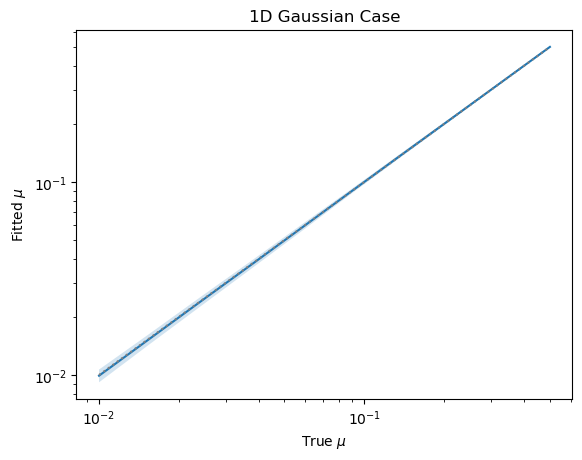

In [4]:
create_mu_plot(mu_hats, title='1D Gaussian Case')

### Analytic Distributions - 3D Gaussian (Uncorrelated)

In [5]:
mu_inj_list = np.logspace(-2, -0.3, 10)
N_trial = 10
N_B = 200000
seed = 2024

mu_S = [1, 3, 5]
mu_B = [6, 4, 2]
sigma = 1

model_S = multivariate_normal(mean=mu_S, cov=sigma, seed=seed)
model_B = multivariate_normal(mean=mu_B, cov=sigma, seed=seed)

mu_hats = scan_mu_hat(mu_inj_list, N_B, N_trial, model_S, model_B, max_workers=25)

Running trial 1 with mu = 0.01
Running trial 2 with mu = 0.01
Running trial 3 with mu = 0.01
Running trial 4 with mu = 0.01
Running trial 5 with mu = 0.01
Running trial 6 with mu = 0.01
Running trial 7 with mu = 0.01
Running trial 8 with mu = 0.01
Running trial 9 with mu = 0.01
Running trial 10 with mu = 0.01
Running trial 1 with mu = 0.015448591479026755
Running trial 2 with mu = 0.015448591479026755
Running trial 3 with mu = 0.015448591479026755
Running trial 4 with mu = 0.015448591479026755
Running trial 5 with mu = 0.015448591479026755
Running trial 6 with mu = 0.015448591479026755
Running trial 7 with mu = 0.015448591479026755
Running trial 8 with mu = 0.015448591479026755
Running trial 9 with mu = 0.015448591479026755
Running trial 10 with mu = 0.015448591479026755
Running trial 1 with mu = 0.023865897868585808
Running trial 2 with mu = 0.023865897868585808
Running trial 3 with mu = 0.023865897868585808
Running trial 4 with mu = 0.023865897868585808
Running trial 5 with mu = 0.02

/tmp/ipykernel_174446/909118199.py:50: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_174446/909118199.py:50: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_174446/909118199.py:50: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_174446/909118199.py:50: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_174446/909118199.py:50: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.


Running trial 6 with mu = 0.023865897868585808
Running trial 7 with mu = 0.023865897868585808
Running trial 8 with mu = 0.023865897868585808
Running trial 9 with mu = 0.023865897868585808
Running trial 10 with mu = 0.023865897868585808
Running trial 1 with mu = 0.036869450645195756
Running trial 2 with mu = 0.036869450645195756
Running trial 3 with mu = 0.036869450645195756
Running trial 4 with mu = 0.036869450645195756
Running trial 5 with mu = 0.036869450645195756
Running trial 6 with mu = 0.036869450645195756
Running trial 8 with mu = 0.036869450645195756
Running trial 7 with mu = 0.036869450645195756
Running trial 9 with mu = 0.036869450645195756
Running trial 10 with mu = 0.036869450645195756
Running trial 1 with mu = 0.056958108107376865
Running trial 2 with mu = 0.056958108107376865
Running trial 3 with mu = 0.056958108107376865
Running trial 4 with mu = 0.056958108107376865
Running trial 5 with mu = 0.056958108107376865
Running trial 6 with mu = 0.056958108107376865
Running tri

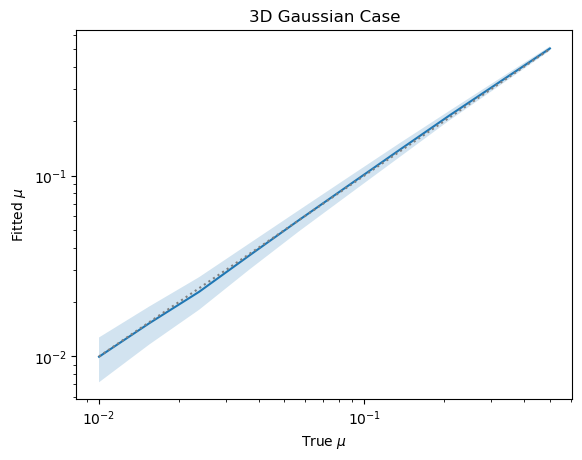

In [6]:
create_mu_plot(mu_hats, title='3D Gaussian Case')

### Analytic Distributions - 2D Gaussian (Correlated)

In [7]:
mu_inj_list = np.logspace(-2, -0.3, 10)
N_trial = 10
N_B = 100000
seed = 2024

mu_S = [1, 3]
mu_B = [1.5, 3.5]
cov_S = np.array([[5, 4.5], [4.5, 5]]) # High Positive Correlation
cov_B = np.array([[3, -2.7], [-2.7, 3]]) # Positive Correlation
sigma = 1

model_S = multivariate_normal(mean=mu_S, cov=cov_S, seed=seed)
model_B = multivariate_normal(mean=mu_B, cov=cov_B, seed=seed)

mu_hats = scan_mu_hat(mu_inj_list, N_B, N_trial, model_S, model_B, max_workers=25)

Running trial 1 with mu = 0.01
Running trial 2 with mu = 0.01
Running trial 3 with mu = 0.01
Running trial 4 with mu = 0.01
Running trial 5 with mu = 0.01
Running trial 6 with mu = 0.01
Running trial 7 with mu = 0.01
Running trial 8 with mu = 0.01
Running trial 9 with mu = 0.01
Running trial 10 with mu = 0.01
Running trial 1 with mu = 0.015448591479026755
Running trial 2 with mu = 0.015448591479026755
Running trial 3 with mu = 0.015448591479026755
Running trial 4 with mu = 0.015448591479026755
Running trial 5 with mu = 0.015448591479026755
Running trial 6 with mu = 0.015448591479026755
Running trial 7 with mu = 0.015448591479026755
Running trial 8 with mu = 0.015448591479026755
Running trial 9 with mu = 0.015448591479026755
Running trial 10 with mu = 0.015448591479026755
Running trial 1 with mu = 0.023865897868585808
Running trial 2 with mu = 0.023865897868585808
Running trial 3 with mu = 0.023865897868585808
Running trial 4 with mu = 0.023865897868585808
Running trial 5 with mu = 0.02

/tmp/ipykernel_174446/909118199.py:50: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_174446/909118199.py:50: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_174446/909118199.py:50: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_174446/909118199.py:50: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_174446/909118199.py:50: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.


Running trial 6 with mu = 0.023865897868585808
Running trial 7 with mu = 0.023865897868585808
Running trial 8 with mu = 0.023865897868585808
Running trial 9 with mu = 0.023865897868585808
Running trial 10 with mu = 0.023865897868585808
Running trial 1 with mu = 0.036869450645195756
Running trial 2 with mu = 0.036869450645195756
Running trial 3 with mu = 0.036869450645195756
Running trial 4 with mu = 0.036869450645195756
Running trial 5 with mu = 0.036869450645195756
Running trial 6 with mu = 0.036869450645195756
Running trial 7 with mu = 0.036869450645195756
Running trial 8 with mu = 0.036869450645195756
Running trial 9 with mu = 0.036869450645195756
Running trial 10 with mu = 0.036869450645195756
Running trial 2 with mu = 0.056958108107376865
Running trial 1 with mu = 0.056958108107376865
Running trial 3 with mu = 0.056958108107376865
Running trial 4 with mu = 0.056958108107376865
Running trial 5 with mu = 0.056958108107376865
Running trial 6 with mu = 0.056958108107376865
Running tri

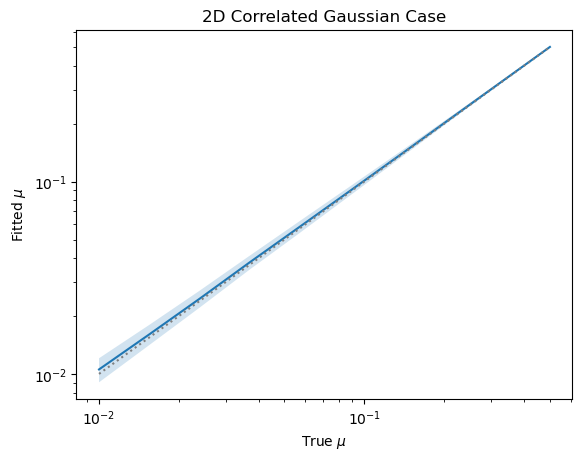

In [8]:
create_mu_plot(mu_hats, title='2D Correlated Gaussian Case')

### Analytic Distributions -  2D Gaussian Signal + Exponential Background Case

In [9]:
class DistributionModel:
    def __init__(self, seed=None):
        self.seed = seed
        self.random_state = np.random.RandomState(seed) if seed is not None else None

    def rvs(self, size):
        raise NotImplementedError

class ExponentialModel(DistributionModel):
    def __init__(self, scale, seed=None):
        super().__init__(seed)
        self.scale = scale

    def rvs(self, size, random_state=None):
        random_state = random_state or self.random_state
        return expon(scale=self.scale).rvs(size=(size, 2), random_state=random_state)

    def pdf(self, x):
        # The PDF of the exponential distribution for each independent variable:
        # f(x) = (1 / scale) * exp(-x / scale) for x > 0
        # In 2D, assuming independence, the joint PDF is the product of the marginal PDFs.
        pdf_x1 = (1 / self.scale) * np.exp(-x[:, 0] / self.scale)
        pdf_x2 = (1 / self.scale) * np.exp(-x[:, 1] / self.scale)
        return pdf_x1 * pdf_x2

In [10]:
mu_inj_list = np.logspace(-2, -0.3, 10)
N_trial = 10
N_B = 100000
seed = 2024

mu_S = [3, 3]
cov_S = np.array([[1, 0], [0, 1]])
model_S = multivariate_normal(mean=mu_S, cov=cov_S, seed=seed)

scale_B = (10 - 1) / np.log(10)
model_B = ExponentialModel(scale=scale_B, seed=seed)

R = get_R(model_B, N_B)
D = get_D(model_S, model_B, N_B, 0.1)

Text(0.5, 0, 'count')

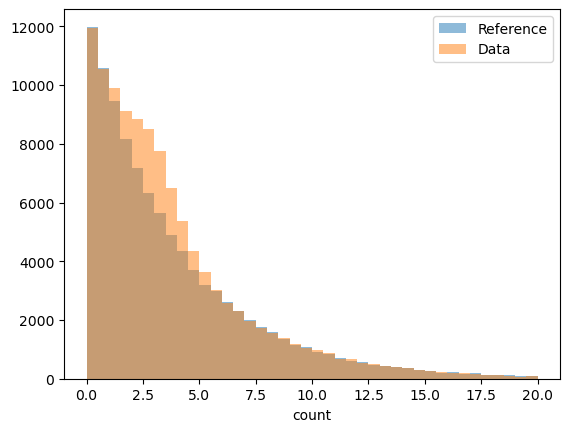

In [11]:
plt.hist(R[:, 0], alpha=0.5, range=(0, 20), bins=40, label='Reference')
plt.hist(D[:, 0], alpha=0.5, range=(0, 20), bins=40, label='Data')
plt.legend()
plt.xlabel('x')
plt.xlabel('count')

In [12]:
mu_hats = scan_mu_hat(mu_inj_list, N_B, N_trial, model_S, model_B, max_workers=25)

Running trial 1 with mu = 0.01
Running trial 8 with mu = 0.01
Running trial 2 with mu = 0.01
Running trial 3 with mu = 0.01
Running trial 4 with mu = 0.01
Running trial 5 with mu = 0.01
Running trial 6 with mu = 0.01
Running trial 7 with mu = 0.01
Running trial 9 with mu = 0.01
Running trial 10 with mu = 0.01
Running trial 1 with mu = 0.015448591479026755
Running trial 2 with mu = 0.015448591479026755
Running trial 4 with mu = 0.015448591479026755
Running trial 3 with mu = 0.015448591479026755
Running trial 5 with mu = 0.015448591479026755
Running trial 6 with mu = 0.015448591479026755
Running trial 7 with mu = 0.015448591479026755
Running trial 8 with mu = 0.015448591479026755
Running trial 9 with mu = 0.015448591479026755
Running trial 10 with mu = 0.015448591479026755
Running trial 1 with mu = 0.023865897868585808
Running trial 2 with mu = 0.023865897868585808
Running trial 3 with mu = 0.023865897868585808
Running trial 4 with mu = 0.023865897868585808
Running trial 5 with mu = 0.02

/tmp/ipykernel_174446/909118199.py:50: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_174446/909118199.py:50: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_174446/909118199.py:50: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_174446/909118199.py:50: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_174446/909118199.py:50: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.


Running trial 6 with mu = 0.023865897868585808
Running trial 7 with mu = 0.023865897868585808
Running trial 8 with mu = 0.023865897868585808
Running trial 9 with mu = 0.023865897868585808
Running trial 10 with mu = 0.023865897868585808
Running trial 1 with mu = 0.036869450645195756
Running trial 2 with mu = 0.036869450645195756
Running trial 3 with mu = 0.036869450645195756
Running trial 4 with mu = 0.036869450645195756
Running trial 5 with mu = 0.036869450645195756
Running trial 7 with mu = 0.036869450645195756
Running trial 6 with mu = 0.036869450645195756
Running trial 8 with mu = 0.036869450645195756
Running trial 9 with mu = 0.036869450645195756
Running trial 10 with mu = 0.036869450645195756
Running trial 1 with mu = 0.056958108107376865
Running trial 2 with mu = 0.056958108107376865
Running trial 3 with mu = 0.056958108107376865
Running trial 4 with mu = 0.056958108107376865
Running trial 5 with mu = 0.056958108107376865
Running trial 6 with mu = 0.056958108107376865
Running tri

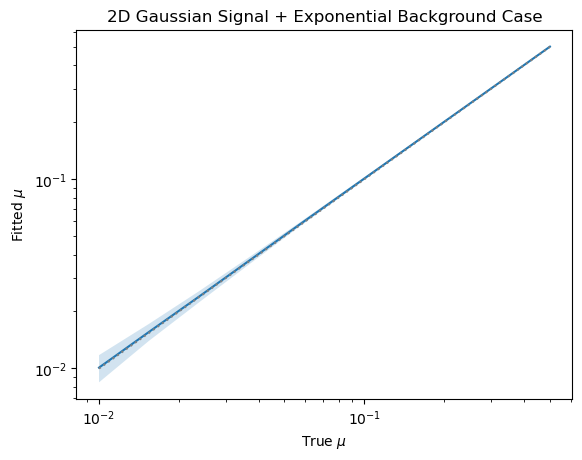

In [13]:
create_mu_plot(mu_hats, title='2D Gaussian Signal + Exponential Background Case')

### Model Training

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal, expon
import matplotlib.pyplot as plt

seed = 2024

# Signal (S): 2D Gaussian with slight correlation
mu_S = [3, 3]
cov_S = np.array([[1.0, 0.5], [0.5, 1.0]])  # Slight correlation
N_S = 100_000  # 100k signals

# Background (B): 2D Exponential, no correlation
scale_B = (10 - 1) / np.log(10)
N_B = 1_000_000  # 1M backgrounds

# Generate the signal and background samples
signal_data = multivariate_normal(mean=mu_S, cov=cov_S).rvs(size=N_S)
background_data = expon(scale=scale_B).rvs(size=(N_B, 2))

signal_labels = np.ones(N_S)  
background_labels = np.zeros(N_B) 

X = np.concatenate([signal_data, background_data], axis=0)
y = np.concatenate([signal_labels, background_labels], axis=0)

# 2. Split into train, validation, and test datasets (50%, 25%, 25%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

2024-10-06 01:44:06.060433: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 01:44:06.061489: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 01:44:06.155935: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 01:44:06.401773: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-06 01:44:08.707442: W tensorflow/compiler/tf2

In [2]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=10,        
    restore_best_weights=True
)

2024-10-06 01:44:14.662553: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # Set a large number of epochs, early stopping will handle when to stop
    batch_size=128,
    callbacks=[early_stopping]
)

Epoch 1/100
4297/4297 [==============================] - 5s 998us/step - loss: 0.1948 - accuracy: 0.9097 - val_loss: 0.1813 - val_accuracy: 0.9131
Epoch 2/100
4297/4297 [==============================] - 4s 954us/step - loss: 0.1826 - accuracy: 0.9123 - val_loss: 0.1815 - val_accuracy: 0.9134
Epoch 3/100
4297/4297 [==============================] - 4s 920us/step - loss: 0.1822 - accuracy: 0.9127 - val_loss: 0.1815 - val_accuracy: 0.9131
Epoch 4/100
4297/4297 [==============================] - 4s 888us/step - loss: 0.1820 - accuracy: 0.9129 - val_loss: 0.1807 - val_accuracy: 0.9134
Epoch 5/100
4297/4297 [==============================] - 4s 928us/step - loss: 0.1818 - accuracy: 0.9129 - val_loss: 0.1812 - val_accuracy: 0.9135
Epoch 6/100
4297/4297 [==============================] - 4s 914us/step - loss: 0.1818 - accuracy: 0.9128 - val_loss: 0.1807 - val_accuracy: 0.9130
Epoch 7/100
4297/4297 [==============================] - 4s 923us/step - loss: 0.1817 - accuracy: 0.9129 - val_loss: 0

In [4]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

8594/8594 [==============================] - 5s 538us/step - loss: 0.1811 - accuracy: 0.9131
Test Accuracy: 91.31%


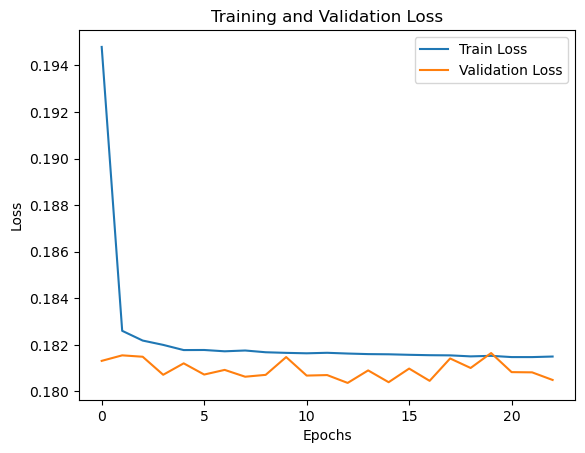

In [5]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [6]:
# Craete weakly datasets

S_test = X_test[y_test == 1]
B_test = X_test[y_test == 0] 

mu = 0.1
N_B = 100_000
N_S = int(mu / (1 - mu) * N_B)

D = np.concatenate([S_test[:N_S], B_test[:N_B]], axis=0)
R = B_test[N_B : 2 * N_B]

Text(0.5, 0, 'x')

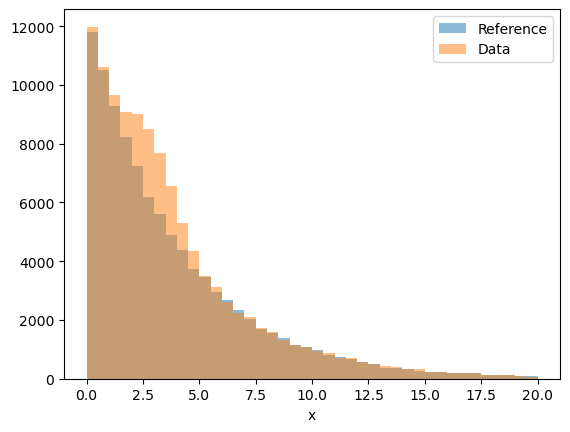

In [7]:
plt.hist(R[:, 0], alpha=0.5, range=(0, 20), bins=40, label='Reference')
plt.hist(D[:, 0], alpha=0.5, range=(0, 20), bins=40, label='Data')
plt.legend()
plt.xlabel('x')

Likelihood ratio from supervised model

In [14]:
# supervised output
FS_ref = model.predict(R).flatten()
kappa = 1 / np.mean(FS_ref / (1 - FS_ref))
likelihood = kappa * (FS_ref / (1 - FS_ref))

3125/3125 [==============================] - 2s 493us/step


Likelihood ratio ($p_S / p_B$) from analytic formula

In [15]:
# calculate the analytic pS/pB

mu_S = [3, 3]
cov_S = np.array([[1.0, 0.5], [0.5, 1.0]])  
model_S = multivariate_normal(mean=mu_S, cov=cov_S)

scale_B = (10 - 1) / np.log(10) 
model_B = expon(scale=scale_B)

pS = model_S.pdf(R)
pB_x1 = model_B.pdf(R[:, 0])
pB_x2 = model_B.pdf(R[:, 1])
pB = pB_x1 * pB_x2

# analytic
pS_over_pB = pS / pB

Checking normalization of pS/pB from ML model

In [16]:
print(f'N_ref: {R.shape[0]}, integral of pS/pB : {pS_over_pB.sum()}')

N_ref: 100000, integral of pS/pB : 100597.87399038428


In [17]:
print(f'N_ref: {R.shape[0]}, integral of likelihood from ML model : {likelihood.sum()}')

N_ref: 100000, integral of likelihood from ML model : 99999.9921875


In [20]:
# Now compare term by term
ratio = pS_over_pB / likelihood
ratio = ratio[np.isfinite(ratio)]

/tmp/ipykernel_210780/3257572001.py:2: RuntimeWarning: divide by zero encountered in divide
  ratio = pS_over_pB / likelihood
/tmp/ipykernel_210780/3257572001.py:2: RuntimeWarning: invalid value encountered in divide
  ratio = pS_over_pB / likelihood


Text(0, 0.5, 'count')

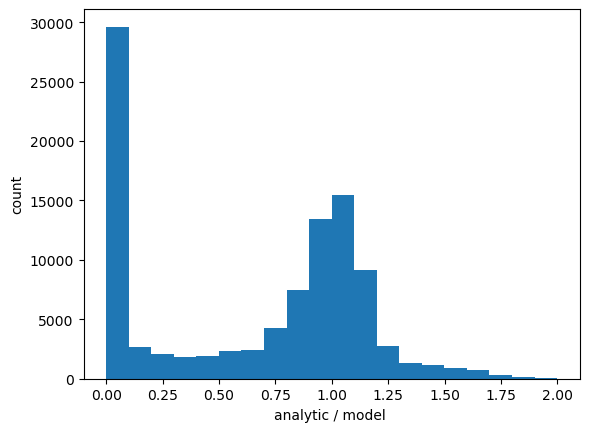

In [21]:
plt.hist(ratio, bins=20)
plt.xlabel('analytic / model ')
plt.ylabel('count')

### Reweight reference distribution to data distribution

In [22]:
WS_analytic = (mu * pS_over_pB + 1 - mu)  / (mu * pS_over_pB + 2 - 2 * mu)
WS_model = (mu * likelihood + 1 - mu)  / (mu * likelihood + 2 - 2 * mu)

In [23]:
rw_analytic = WS_analytic / (1 - WS_analytic)
rw_model = WS_model / (1 - WS_model)

Text(0, 0.5, 'Fraction of Events')

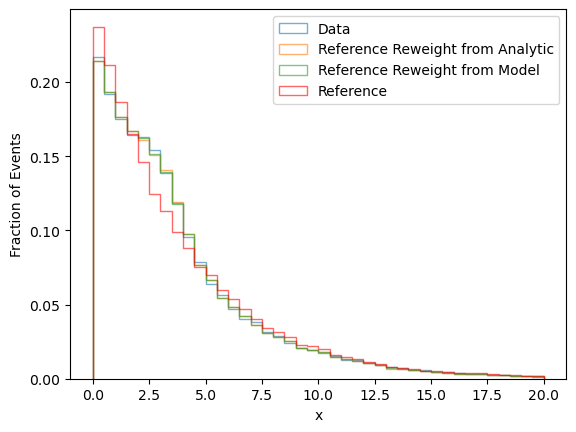

In [24]:
plt.hist(D[:, 0], bins=40, range=(0, 20), alpha=0.6, label='Data', histtype='step', density=True)
plt.hist(R[:, 0], weights=rw_analytic, bins=40, range=(0, 20), alpha=0.6, label='Reference Reweight from Analytic', histtype='step', density=True)
plt.hist(R[:, 0], weights=rw_model, bins=40, range=(0, 20), alpha=0.6, label='Reference Reweight from Model', histtype='step', density=True)
plt.hist(R[:, 0], bins=40, range=(0, 20), alpha=0.6, label='Reference', histtype='step', color='r', density=True)
plt.legend()
plt.xlabel('x')
plt.ylabel('Fraction of Events')

### Train for mu

In [25]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense

class MinMaxRegularizer(tf.keras.regularizers.Regularizer):
  def __init__(self, min_val, max_val, l=1.0):
      self.min_val = min_val
      self.max_val = max_val
      self.l = l

  def __call__(self, x):
      x_under = tf.cast(tf.less(x, self.min_val), dtype=tf.float32)
      x_over  = tf.cast(tf.greater(x, self.max_val), dtype=tf.float32)
      under_penalty = (tf.exp(self.min_val - x) - 1)
      over_penalty = (tf.exp(x - self.max_val) - 1)
      penalty = self.l * tf.math.reduce_sum(((x_under * under_penalty) + (x_over * over_penalty)))
      return penalty

  def get_config(self):
      return {'l': float(self.l),
              'min_val': float(self.min_val),
              'max_val': float(self.max_val)}

def get_single_parameter_model(default,
                               name = None,
                               exponential=False,
                               regularizer=None):
    inputs = Input(shape=(1,))
    outputs = Dense(1, use_bias=False,
                    kernel_initializer=tf.constant_initializer(float(default)),
                    kernel_regularizer=regularizer,
                    activation='linear',
                    name=name)(inputs)
    if exponential:
        outputs = tf.exp(outputs)
    return Model(inputs=inputs, outputs=outputs)

def create_ws_model(fs_model, feature_dim, kappa=1.0):
    x = Input(shape=(feature_dim,))
    fs_out = fs_model(x)
    mu_input = get_single_parameter_model(-4., name='mu',
                                          exponential=True,
                                          regularizer=MinMaxRegularizer(-10.0, 0.0),)
    mu_out = mu_input(tf.ones_like(x)[:, :1])
    LLR = fs_out / (1 - fs_out + 1e-5)
    if kappa == 'trainable':
        kappa_input = get_single_parameter_model(5., name='kappa',
                                                 exponential=False,
                                                 regularizer=MinMaxRegularizer(1, 30))
        kappa = kappa_input(tf.ones_like(x)[:, :1])
    LLR_xs = 1. + mu_out * (LLR * kappa - 1.)
    ws_out = LLR_xs / (LLR_xs + 1 - mu_out )
    ws_model = tf.keras.Model(inputs=x, outputs=ws_out, name='SemiWeakly')
    return ws_model

In [26]:
# Craete weakly datasets

S_test = X_test[y_test == 1]
B_test = X_test[y_test == 0]

N_B = 100000
mu = 0.01
N_S = int(mu / (1 - mu) * N_B)

D = np.concatenate([S_test[:N_S], B_test[:N_B]], axis=0)
R = B_test[N_B : 2 * N_B]

X = np.concatenate([D, R])
Y = np.concatenate([np.ones(D.shape[0]), np.zeros(R.shape[0])])

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.5, random_state=2024)

In [28]:
for layer in model.layers:
    layer.trainable = False

In [31]:
ws_model = create_ws_model(model, feature_dim=2, kappa=kappa)
ws_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=10,        
    restore_best_weights=True
)

ws_model.fit(x_train, y_train,
             validation_data=(x_val, y_val),
             epochs=1000,
             batch_size=1024,
             callbacks=[early_stopping])

Epoch 1/1000
99/99 [==============================] - 1s 3ms/step - loss: 0.6931 - accuracy: 0.5015 - val_loss: 0.6932 - val_accuracy: 0.5022
Epoch 2/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.5022
Epoch 3/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5014 - val_loss: 0.6932 - val_accuracy: 0.5015
Epoch 4/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.4999 - val_loss: 0.6931 - val_accuracy: 0.5017
Epoch 5/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5020 - val_loss: 0.6931 - val_accuracy: 0.5013
Epoch 6/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5021 - val_loss: 0.6931 - val_accuracy: 0.5022
Epoch 7/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5017 - val_loss: 0.6931 - val_accuracy: 0.5021
Epoch 

In [34]:
ws_model.evaluate(x_train, y_train)

3141/3141 [==============================] - 2s 566us/step - loss: 0.6931 - accuracy: 0.5007


[0.6930612325668335, 0.5007014870643616]

In [40]:
weights = {}
for weight in ws_model.trainable_weights:
    name = weight.name.split('/')[0]
    weights[name] = weight[0][0]
print(f'predicted mu: {np.exp(weights["mu"])}')
print(f'truth mu: {mu}')

predicted mu: 0.010450861416757107
truth mu: 0.01
